# Chapter 2

## 2E1

Which of the expressions below correspond to the statement: the probability of rain on Monday? 

(1) $Pr(\text{rain})$  
(2) $Pr(\text{rain|Monday})$  
(3) $Pr(\text{Monday|rain})$  
(4) $Pr(\text{rain, Monday})/ Pr(\text{Monday})$ 

### Ans

$$
\frac{Pr(\text{rain, Monday})}{Pr(\text{Monday})} = Pr(\text{rain} \mid \text{Monday})
$$


## 2E2

Which of the following statements corresponds to the expression: $Pr(\text{Monday} \mid \text{rain})$? 

(1) The probability of rain on Monday.  
(2) The probability of rain, given that it is Monday.  
(3) The probability that it is Monday, given that it is raining.  
(4) The probability that it is Monday and that it is raining.  


### Ans

(3) The probability that it is Monday, given that it is raining.

## 2E3

2E3. Which of the expressions below correspond to the statement: _the probability that it is Monday, given that it is raining_?

(1) $Pr(\text{Monday} \mid \text{rain})$

(2) $Pr(\text{rain} \mid \text{Monday})$

(3) $Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday})$

(4) $Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday}) / Pr(\text{rain})$

(5) $Pr(\text{Monday} \mid \text{rain}) \cdot Pr(\text{rain}) / Pr(\text{Monday})$

### Ans

(1) $Pr(\text{Monday} \mid \text{rain})$

(4) 
$$
\begin{equation}
\begin{aligned}
Pr(\text{rain} \mid \text{Monday}) \cdot Pr(\text{Monday}) / Pr(\text{rain}) 
&= \frac{Pr(\text{rain}, \text{Monday})}{Pr(\text{rain})} \\
&= Pr(\text{Monday} \mid \text{rain}) \\
\end{aligned}
\end{equation}
$$


## 2E4.

The Bayesian statistician Bruno de Finetti (1906–1985) began his 1973 book on probability theory with the declaration: “PROBABILITY DOES NOT EXIST.” The capitals appeared in the original,  so I imagine de Finetti wanted us to shout this statement. What he meant is that probability is a device for describing uncertainty from the perspective of an observer with limited knowledge; it has no  objective reality. Discuss the globe tossing example from the chapter, in light of this statement. What  does it mean to say “the probability of water is 0.7”?

### Ans


In the case of the globe tossing example, it means that there is some "true" proportion of water to land. However, "truth"s like thees are usually fully known to us for many reasons (e.g. due to finite sample size, measurement error, unobserved variables, missing data, etc.). We can model our uncertainty using probability theory. Hopefully our model correctly represents truths, such as the "true" proportion of water to land. However, that's not guaranteed. When we say "the probability of water is 0.7," colloquially, it means that we *think* that the probability of water is somewhere around 70%, given this point in time. We did not give a lot of significant digits. It might not actually be exactly 0.7, but we _think_ it is somewhere around there. It still denotes uncertainty of the observer, given what we currently know.


## 2M1.

2M1. Recall the globe tossing model from the chapter. Compute and plot the grid approximate  posterior distribution for each of the following sets of observations. In each case, assume a uniform  prior for p.  

(1) W, W, W  
(2) W, W, W, L  
(3) L, W, W, L, W, W, W 

### Ans

We'll instead use rejection sampling and ABC-SMC:

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.65it/s]


(<Figure size 576x576 with 4 Axes>,
 array([<AxesSubplot:title={'center':'obs: [1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [1 1 1 0]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [0 1 1 0 1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Full batch'}, ylabel='Density'>],
       dtype=object))

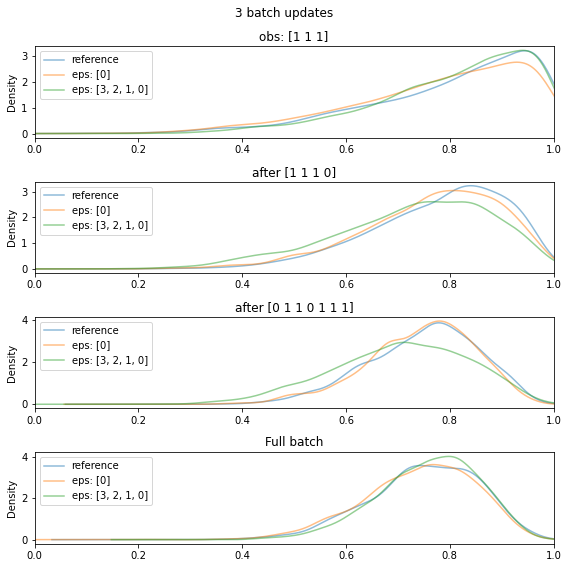

In [8]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


num_particles = 2000
obs = np.array([
    1,1,1,
    1,1,1,0,
    0,1,1,0,1,1,1
])

epsilons_list = [[0], [3,2,1,0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    return np.random.binomial(n=1, p=priors['beta'], size=len(obs))


data_to_display = [
    [
        {
            'title': f"obs: {obs[:3]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs[:3].sum() + 1, 
                        len(obs[:3]) - obs[:3].sum() + 1,
                        num_particles
                    )
                })

            ]
        },
        {
            'title': f"after {obs[3:7]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs[:7].sum() + 1, 
                        len(obs[:7]) - obs[:7].sum() + 1,
                        num_particles
                    )
                })
            ]
        },
        {
            'title': f"after {obs[7:]}",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs.sum() + 1, 
                        len(obs) - obs.sum() + 1,
                        num_particles
                    )
                })
            ]
        },
        {
            'title': "Full batch",
            'data': [
                pd.DataFrame({
                    'reference': np.random.beta(
                        obs.sum() + 1, 
                        len(obs) - obs.sum() + 1,
                        num_particles
                    )
                })
            ]
        }
    ]
]


for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Beta(alpha=1, beta=1, name="beta"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[:3],
        distance=distance,
    )

    data_to_display[0][0]['data'].append(
        pd.DataFrame(models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )


    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()

    # Update with 2nd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[3:7],
        distance=distance,
    )

    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()
    
    data_to_display[0][1]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )

    # Update with 3rd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[7:],
        distance=distance,
    )

    data_to_display[0][2]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'beta': f'eps: {epsilons}'}
        )
    )

    models_full_batch = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Beta(alpha=1, beta=1, name="beta"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update full batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models_full_batch,
        obs=obs,
        distance=distance,
    )
    
    data_to_display[0][3]['data'].append(
        pd.DataFrame(
            models_full_batch[0].prev_accepted_proposals
        ).rename(columns={'beta': f'eps: {epsilons}'})
    )

create_images_from_data(
    data={
        'title': '3 batch updates',
        'data': data_to_display
    },
    xlim=(0,1),
    figsize_mult=(2,8)
)

Using the [unlikely](https://github.com/Edderic/unlikely) library, Bayesian updating with the full batch, along with Bayesian updating through mini batches with only epsilon 0, seems to be more accurate than updating through mini batches with many epsilons. Mini batch updating leads to overinflated posterior distributions.

## 2M2

Now assume a prior for p that is equal to zero when p < 0.5 and is a positive constant when  p ≥ 0.5. Again compute and plot the grid approximate posterior distribution for each of the sets of observations in the problem just above. 

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 248.04it/s]


(<Figure size 576x576 with 4 Axes>,
 array([<AxesSubplot:title={'center':'obs: [1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [1 1 1 0]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'after [0 1 1 0 1 1 1]'}, ylabel='Density'>,
        <AxesSubplot:title={'center':'Full batch'}, ylabel='Density'>],
       dtype=object))

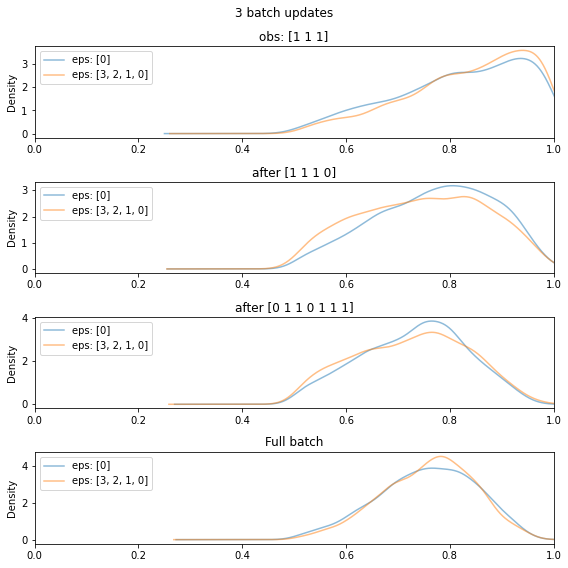

In [1]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Uniform
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data
import pdb

num_particles = 2000
obs = np.array([
    1,1,1,
    1,1,1,0,
    0,1,1,0,1,1,1
])

epsilons_list = [[0], [3,2,1,0]]


def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    
    return np.random.binomial(n=1, p=priors['uniform'], size=len(obs))
    
data_to_display = [
    [
        {
            'title': f"obs: {obs[:3]}",
            'data': []
        },
        {
            'title': f"after {obs[3:7]}",
            'data': []
        },
        {
            'title': f"after {obs[7:]}",
            'data': []
        },
        {
            'title': "Full batch",
            'data': []
        }
    ]
]


for row, epsilons in enumerate(epsilons_list):
    models = Models(
        [
            Model(
                name='Uniform over (0.5, 1)',
                priors=[
                    Uniform(alpha=0.5, beta=1, name="uniform"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update with 1st batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[:3],
        distance=distance,
    )

    data_to_display[0][0]['data'].append(
        pd.DataFrame(models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )


    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()

    # Update with 2nd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[3:7],
        distance=distance,
    )

    # The posterior distribution becomes the prior
    models.use_distribution_from_samples()
    
    data_to_display[0][1]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )

    # Update with 3rd batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models,
        obs=obs[7:],
        distance=distance,
    )

    data_to_display[0][2]['data'].append(
        pd.DataFrame(
            models[0].prev_accepted_proposals).rename(
            columns={'uniform': f'eps: {epsilons}'}
        )
    )

    models_full_batch = Models(
        [
            Model(
                name='flat prior',
                priors=[
                    Uniform(alpha=0.5, beta=1, name="uniform"),
                ],
                simulate=simulate,
                prior_model_proba=1,
            ),
        ]
    )

    # Update full batch
    abc_smc(
        num_particles=num_particles,
        epsilons=epsilons,
        models=models_full_batch,
        obs=obs,
        distance=distance,
    )
    
    data_to_display[0][3]['data'].append(
        pd.DataFrame(
            models_full_batch[0].prev_accepted_proposals
        ).rename(columns={'uniform': f'eps: {epsilons}'})
    )

create_images_from_data(
    data={
        'title': '3 batch updates',
        'data': data_to_display
    },
    xlim=(0,1),
    figsize_mult=(2,8)
)

## 2M3

Suppose there are two globes, one for Earth and one for Mars. The Earth globe is 70% covered  in water. The Mars globe is 100% land. Further suppose that one of these globes—you don’t know  which—was tossed in the air and produced a “land” observation. Assume that each globe was equally  likely to be tossed. Show that the posterior probability that the globe was the Earth, conditional on  seeing “land” (Pr(Earth|land)), is 0.23.  

In [3]:
Beta(alpha=700, beta=300, name="proba_water").get_name()

'proba_water'

We can construct two models of the world: one corresponding to the Earth and one corresponding to Mars. We then run the ABC-SMC algorithm. Afterwards, we compute to see how many times the samples produced from Earth are accepted and compare that to how many times the samples from Mars were accepted. We then normalize those two numbers by the number of total samples. 

In [7]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    
    return np.random.binomial(n=1, p=priors['proba_water'], size=len(obs))
    
def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

obs = np.array([0]) # land

num_particles = 2000
epsilons = [0]

models = Models(
    [
        Model(
            name='Earth produced it',
            priors=[
                Beta(alpha=700 + 1, beta=300 + 1, name="proba_water")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        ),

        Model(
            name='Mars produced it',
            priors=[
                Beta(alpha=1, beta=1001, name="proba_water")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        )
    ]
)

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
)

models.get_posterior_probabilities()


100%|████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1950.46it/s]


{'Earth produced it': 0.2325, 'Mars produced it': 0.7675}

$P(\text{Earth} \mid \text{Data}) \approx 0.23$ 

## 2M4

Suppose you have a deck with only three cards. Each card has two sides, and each side is either  black or white. One card has two black sides. The second card has one black and one white side. The  third card has two white sides. Now suppose all three cards are placed in a bag and shuffled. Someone  reaches into the bag and pulls out a card and places it flat on a table. A black side is shown facing up,  but you don’t know the color of the side facing down. Show that the probability that the other side is  also black is 2/3. Use the counting method (Section 2 of the chapter) to approach this problem. This  means counting up the ways that each card could produce the observed data (a black side facing up  on the table).

In [10]:
np.random.randint(0,1)

0

In [21]:
import numpy as np


card_1 = [0, 0]
card_2 = [0, 1]
card_3 = [1, 1]


probas = [1/3, 1/3, 1/3]
cards = [card_1, card_2, card_3]

def simulate_card_selection(cards, probas):
    """
    Let Black be represented by 0, and White be represented by 1.
    """
    
    count_black_other_side = 0
    num_sims = 10000
    num_div = 0
    
    for i in range(num_sims):
        
        # choose a card randomly
        chosen_card_index = np.random.choice(list(range(len(cards))), p=probas)
        
        chosen_card = cards[chosen_card_index]
        
        # choose a side to display
        chosen_side_to_show_index = np.random.randint(0,2)
        other_side_index = 1 - chosen_side_to_show_index
        chosen_side_to_show = chosen_card[chosen_side_to_show_index]
        
        if chosen_side_to_show == 0:
            num_div += 1
            
            if chosen_card[other_side_index] == 0:  
                count_black_other_side += 1
            
    return count_black_other_side / num_div

print(f"Probability that the other side is black: {round(simulate_card_selection(cards, probas), 2)}")

Probability that the other side is black: 0.67


## 2M5

2M5. Now suppose there are four cards: B/B, B/W, W/W, and another B/B. Again suppose a card is  drawn from the bag and a black side appears face up. Again calculate the probability that the other  side is black.

In [19]:
cards = [(0,0), (0,1), (1,1), (0,0)]
print(f"Probability that the other side is black: {round(simulate_card_selection(cards), 2)}")

Probability that the other side is black: 0.81


## 2M6

Imagine that black ink is heavy, and so cards with black sides are heavier than cards with white  sides. As a result, it’s less likely that a card with black sides is pulled from the bag. So again assume  there are three cards: B/B, B/W, and W/W. After experimenting a number of times, you conclude that  for every way to pull the B/B card from the bag, there are 2 ways to pull the B/W card and 3 ways to  pull the W/W card. Again suppose that a card is pulled and a black side appears face up. Show that  the probability the other side is black is now 0.5. Use the counting method, as before. 

In [24]:
cards = [(0,0), (0,1), (1,1)]
probas = np.array([1, 2, 3])
probas = probas / probas.sum() # Normalize
print(f"Probability that the other side is black: {round(simulate_card_selection(cards, probas), 2)}")

Probability that the other side is black: 0.49


## 2M7

Assume again the original card problem, with a single card showing a black side face up. Before  looking at the other side, we draw another card from the bag and lay it face up on the table. The face  that is shown on the new card is white. Show that the probability that the first card, the one showing  a black side, has black on its other side is now 0.75. Use the counting method, if you can. Hint: Treat  this like the sequence of globe tosses, counting all the ways to see each observation, for each possible  first card.

In [31]:
def simulate_card_selection_2M7(cards, probas):
    """
    Let Black be represented by 0, and White be represented by 1.
    """
    
    count_black_other_side = 0
    num_sims = 10000
    num_div = 0
    
    for i in range(num_sims):
        
        # choose a card randomly
        chosen_card_index = np.random.choice(
            list(range(len(cards))), 
            p=probas
        )
        
        chosen_card = cards[chosen_card_index]
        
        # choose a side to display
        chosen_side_to_show_index = np.random.randint(0,2)
        other_side_index = 1 - chosen_side_to_show_index
        chosen_side_to_show = chosen_card[chosen_side_to_show_index]
        
        possible_other_chosen_card_indices = list(
            set(list(range(len(cards)))) - set({chosen_card_index})
        )

        other_card_index = np.random.choice(possible_other_chosen_card_indices)
        other_card = cards[other_card_index]
        other_card_side_to_show_index = np.random.randint(0,2)
        other_card_side_to_hide_index = 1 - other_card_side_to_show_index
        
        other_card_side_to_show = other_card[other_card_side_to_show_index]
        other_card_side_to_hide = other_card[other_card_side_to_hide_index]
        
        
        if chosen_side_to_show == 0 and other_card_side_to_show == 1:
            num_div += 1
            
            if chosen_card[other_side_index] == 0:  
                count_black_other_side += 1
            
    return count_black_other_side / num_div

cards = [(0,0), (0,1), (1,1)]
probas = np.array([1, 1, 1])
probas = probas / probas.sum()
print(f"Probability that the other side is black: {round(simulate_card_selection_2M7(cards, probas), 2)}")

Probability that the other side is black: 0.76


## 2H1

Suppose there are two species of panda bear. Both are equally common in the wild and live in the same places. They look exactly alike and eat the same food, and there is yet no genetic assay  capable of telling them apart. They differ however in their family sizes. Species A gives birth to twins 10% of the time, otherwise birthing a single infant. Species B births twins 20% of the time, otherwise  birthing singleton infants. Assume these numbers are known with certainty, from many years of field research. 

Now suppose you are managing a captive panda breeding program. You have a new female panda  of unknown species, and she has just given birth to twins. What is the probability that her next birth  will also be twins? 

In [49]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    
    return np.random.binomial(n=1, p=priors['proba_twin'], size=len(obs))
    
def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

obs = np.array([1]) # observe a twin birth

num_particles = 5000
epsilons = [0]

models = Models(
    [
        Model(
            name='Species A',
            priors=[
                # Species A gives birth to twins 10% of the time
                Beta(alpha=1000 + 1, beta=9000 + 1, name="proba_twin")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        ),

        Model(
            name='Species B',
            priors=[
                # Species B gives birth to twins 20% of the time
                Beta(alpha=2000 + 1, beta=8000 + 1, name="proba_twin")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        )
    ]
)

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
)

models.get_posterior_probabilities()


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 350.27it/s]


{'Species A': 0.3294, 'Species B': 0.6706}

There's a 1/3 chance that the species of mother is A, while there's a 2/3 chance that it is B. The data generating process in terms of the DAG is:

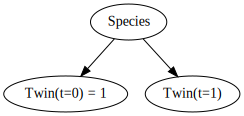

In [41]:
import graphviz

from graphviz import Digraph

dag = Digraph('species-birthing-dag')
dag.edge('Species', 'Twin(t=0) = 1')
dag.edge('Species', 'Twin(t=1)')
dag

$$
\begin{equation}
\begin{aligned}
  P(T_{t=1} \mid T_{t=0} = 1) &= \sum_s P(T_{t=1}, S=s \mid T_{t=0} = 1) \\
&= \sum_s P(T_{t=1} \mid S=s, T_{t=0} = 1) \cdot P(S=s \mid T_{t=1}) \\
&= \sum_s P(T_{t=1} \mid S=s) \cdot P(S=s \mid T_{t=0} = 1) & \text{Once you know the Species, a previous birth doesn't tell you anything about the next birth}\\
\end{aligned}
\end{equation}
$$


From running the above code, we have $P(S=a \mid T_{t=0}=1) \approx 0.334$ and $P(S=b \mid T_{t=0}=1) \approx 0.666$. We are also given $P(T_{t=1} \mid S=s)$. When $S=a$, we have  $P(T_{t=1} \mid S=a) = 0.10$. For $S=b$, it is double that: $P(T_{t=1} \mid S=a) = 0.20$.

Thus, the above equation reduces to:

$$
\begin{equation}
\begin{aligned}
\sum_s P(T_{t=1} \mid S=s) \cdot P(S=s \mid T_{t=0} = 1) &=
P(T_{t=1} \mid S=a) \cdot P(S=a \mid T_{t=0} = 1) \\
&\quad + P(T_{t=1} \mid S=b) \cdot P(S=b \mid T_{t=0} = 1) \\
&= 0.1 \cdot 0.334 + 0.2 \cdot 0.666 \\
&= 0.1666 \\
&\approx 0.17
\end{aligned}
\end{equation}
$$



We could find the same answer by using our updated model of the world ($P(S=s \mid T_{t=0} = 1)$) to produce imaginary data for the next birth:

In [50]:
simulate(
    models[0].prev_accepted_proposals, 
    models[0].prev_accepted_proposals
).mean() * models.get_posterior_probabilities()['Species A'] + simulate(
    models[1].prev_accepted_proposals, 
    models[1].prev_accepted_proposals
).mean() * models.get_posterior_probabilities()['Species B']

0.17020000000000002

## 2H2

Recall all the facts from the problem above. Now compute the probability that the panda we  have is from species A, assuming we have observed only the first birth and that it was twins.

In [52]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data


def simulate(priors, obs):
    """
    Data is binomially distributed.
    """
    
    return np.random.binomial(n=1, p=priors['proba_twin'], size=len(obs))
    
def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

obs = np.array([1]) # observe a twin birth

num_particles = 5000
epsilons = [0]

models = Models(
    [
        Model(
            name='Species A',
            priors=[
                # Species A gives birth to twins 10% of the time
                Beta(alpha=1000 + 1, beta=9000 + 1, name="proba_twin")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        ),

        Model(
            name='Species B',
            priors=[
                # Species B gives birth to twins 20% of the time
                Beta(alpha=2000 + 1, beta=8000 + 1, name="proba_twin")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        )
    ]
)

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
)

print(
    "The probabilities of the species of the mother, given we observed twins: "\
    + f"{models.get_posterior_probabilities()}" 
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 358.93it/s]

The probabilities of the species of the mother, given we observed twins: {'Species A': 0.3496, 'Species B': 0.6504}


## 2H3

Continuing on from the previous problem, suppose the same panda mother has a second birth  and that it is not twins, but a singleton infant. Compute the posterior probability that this panda is species A.

In [54]:
models.use_distribution_from_samples() # set posterior distribution samples as new prior.

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=np.array([0]),
    distance=distance,
)

print(
    "The probabilities of the species of the mother, given we observed 1 twin and 1 singleton: "\
    + f"{models.get_posterior_probabilities()}" 
)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:00<00:00, 5901.81it/s]

The probabilities of the species of the mother, given we observed 1 twin and 1 singleton: {'Species A': 0.3918, 'Species B': 0.6082}


Using the posterior from 2H2 as the prior, and combining that with the observation of a singleton infant, Species A became more likely, but Species B is still the more probable.

## 2H4

A common boast of Bayesian statisticians is that Bayesian inference makes it easy to use all of  the data, even if the data are of different types.  So suppose now that a veterinarian comes along who has a new genetic test that she claims can  identify the species of our mother panda. But the test, like all tests, is imperfect. This is the information you have about the test:  

• The probability it correctly identifies a species A panda is 0.8.  
• The probability it correctly identifies a species B panda is 0.65. 

The vet administers the test to your panda and tells you that the test is positive for species A. First  ignore your previous information from the births and compute the posterior probability that your  panda is species A. Then redo your calculation, now using the birth data as well.

### Using vet genetic test only:

In [2]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data

def simulate(priors, obs):
    return np.random.binomial(n=1, p=priors['doc_proba'], size=len(obs))
        
def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    return abs(x.sum() - y.sum())

obs = np.array([1]) # Doctor claims a species A

num_particles = 5000
epsilons = [0]

models = Models(
    [
        Model(
            name='Species A',
            priors=[
                Beta(alpha=8000 + 1, beta=2000 + 1, name="doc_proba")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        ),

        Model(
            name='Species B',
            priors=[
                Beta(alpha=3500 + 1, beta=6500 + 1, name="doc_proba")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        )
    ]
)

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
)

print(
    "The probabilities of the species of the mother, given the doctor's claim: "\
    + f"{models.get_posterior_probabilities()}" 
)


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:02<00:00, 1856.05it/s]


The probabilities of the species of the mother, given the doctor's claim: {'Species A': 0.7004, 'Species B': 0.2996}


In [4]:
list(np.array([1])) + list(np.array([1,2]))

[1, 1, 2]

In [8]:
import numpy as np
import pandas as pd
from unlikely.models import Models, Model
from unlikely.priors import Beta
from unlikely.engine import abc_smc
from unlikely.misc import create_images_from_data

def simulate(priors, obs):
    genetic_test = np.random.binomial(n=1, p=priors['genetic_test'], size=1)
    twin_birth = np.random.binomial(n=1, p=priors['twin_birth'], size=len(obs['twin_birth']))
    
    return {
        'genetic_test': genetic_test,
        'twin_birth': twin_birth
    }
        
def distance(x,y):
    """
    Compare the number of ones in one vs. the other.
    """
    
    x_list = list(x['genetic_test']) + list(x['twin_birth'])
    y_list = list(y['genetic_test']) + list(y['twin_birth'])
    
    return abs(x['genetic_test'] - y['genetic_test']) \
        + sum(abs(x['twin_birth'] - y['twin_birth']))

obs = {
    'genetic_test': [1], # Species A
    'twin_birth': [1, 0]
}

np.array([1]) # Doctor claims a species A

num_particles = 5000
epsilons = [0]

models = Models(
    [
        Model(
            name='Species A',
            priors=[
                Beta(alpha=8000 + 1, beta=2000 + 1, name="genetic_test"),
                Beta(alpha=1000 + 1, beta=9000 + 1, name="twin_birth")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        ),

        Model(
            name='Species B',
            priors=[
                Beta(alpha=3500 + 1, beta=6500 + 1, name="genetic_test"),
                Beta(alpha=2000 + 1, beta=8000 + 1, name="twin_birth")
            ],
            simulate=simulate,
            prior_model_proba=0.5,
        )
    ]
)

abc_smc(
    num_particles=num_particles,
    epsilons=epsilons,
    models=models,
    obs=obs,
    distance=distance,
)

print(
    "The probabilities of the species of the mother, given the doctor's claim and births: "\
    + f"{models.get_posterior_probabilities()}" 
)


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:41<00:00, 121.86it/s]

The probabilities of the species of the mother, given the doctor's claim and births: {'Species A': 0.5634, 'Species B': 0.4366}
